In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append('..')

In [73]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from src.augmentations import RandomCrop
from src.dataset import SartoriusDataset
from src.losses import ContrastiveLoss, ContrastiveLossOnPatches, contrastive_loss_on_patches

In [54]:
y_pred = tf.random.uniform([1, 512, 704, 8])
y_true = tf.random.uniform([1, 512, 704, 1], 0, 300, dtype=tf.int32)

In [8]:
loss = ContrastiveLoss()(y_true, y_pred)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=8.526549>

In [69]:
loss = ContrastiveLossOnPatches(window_size=85)(y_true, y_pred)
loss.numpy()

8.953507

In [59]:
def flatten(x):
    return tf.reshape(x, [-1])


def _generate_random_patch_mask(shape, w_size):
    b, h, w = shape

    x_coord = tf.random.uniform((b, 1), 0, w - w_size, dtype=tf.int64) + tf.range(w_size, dtype=tf.int64)[None, :]
    y_coord = tf.random.uniform((b, 1), 0, h - w_size, dtype=tf.int64) + tf.range(w_size, dtype=tf.int64)[None, :]

    def build_indices(x_coord, y_coord):
        xx, yy = tf.meshgrid(x_coord, y_coord)
        indices = tf.concat([flatten(yy)[:, None], flatten(xx)[:, None]], axis=-1)

        return indices

    def compute_mask(inputs):
        x_coord, y_coord = inputs

        indices = build_indices(x_coord, y_coord)
        mask = tf.SparseTensor(indices, 
                               tf.ones(indices.shape[0], dtype=tf.bool), 
                               [h, w])

        return tf.sparse.to_dense(mask)

    mask = tf.map_fn(
        compute_mask, 
        (x_coord, y_coord), 
        fn_output_signature=tf.bool
    )

    return mask

In [64]:
mask = _generate_random_patch_mask([8, 544, 704], 85)
mask.shape

TensorShape([8, 544, 704])

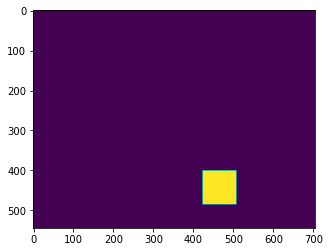

In [74]:
plt.imshow(mask.numpy()[7])

In [76]:
tf.random.uniform([544, 704, 1])[mask[0]].shape

TensorShape([7225, 1])

In [40]:
from src.losses import (_sample_indices, _contour_mask, 
                        _build_masks, contrastive_loss_with_contours)

In [36]:
indices = _sample_indices(1, 100, 10, replace=True)
indices

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([31, 24, 96, 43,  1, 74, 44, 98, 91, 98], dtype=int32)>

In [48]:
path = Path('/Users/constantine/sartorius-competition/sartorius-cell-instance-segmentation/train')
augmentations = [RandomCrop((512, 704))]

ds = SartoriusDataset(path, augmentations=augmentations)
dataset = ds.dataset
dataset

<BatchDataset shapes: ((None, 512, 704, 1), (None, 512, 704, 1)), types: (tf.float32, tf.int32)>

In [49]:
images, masks = tuple(next(dataset.as_numpy_iterator()))
images.shape, masks.shape

((16, 512, 704, 1), (16, 512, 704, 1))

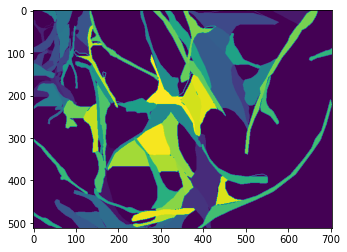

In [50]:
plt.imshow(masks[0])

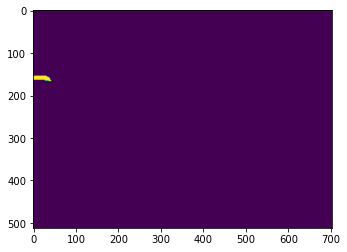

In [51]:
plt.imshow(masks[0] == 3)

In [52]:
cont_mask = _contour_mask(masks[0] == 3).numpy()
cont_mask.shape, cont_mask.sum(), cont_mask.min(), cont_mask.max(), 

((512, 704, 1), 611, False, True)

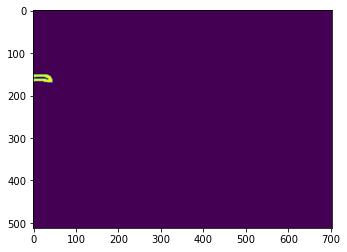

In [53]:
plt.imshow(cont_mask)

In [54]:
mask_contours = _build_masks(masks[0], indices)
mask_contours.shape

TensorShape([10, 512, 704, 1])

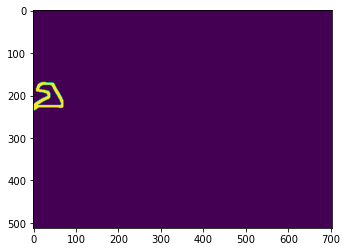

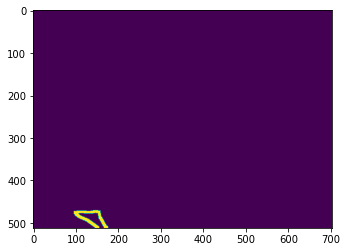

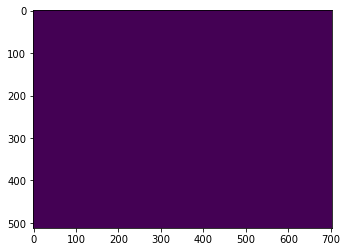

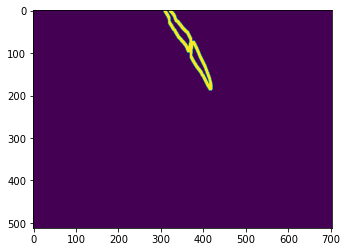

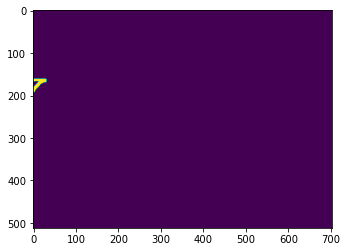

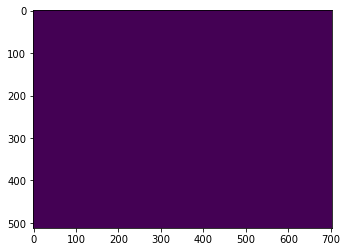

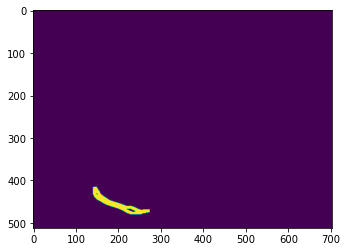

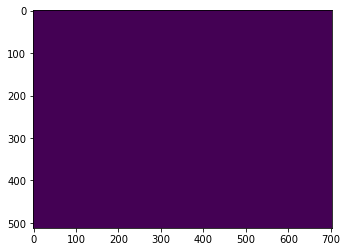

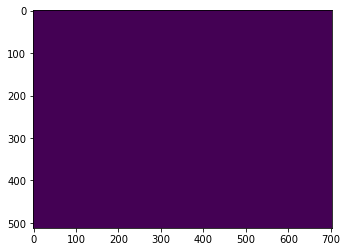

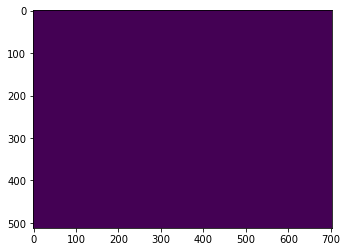

In [55]:
for mask in mask_contours:
    plt.imshow(mask)
    plt.show()

In [59]:
preds = tf.random.uniform(masks.shape[:3] + (8,))

loss = contrastive_loss_with_contours(masks, preds)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=6.2212386>

In [132]:
from src.losses import (_generate_bbox_mask, _build_mask_from_bbox, 
                        _tf_compute_bboxes, _py_compute_bboxes, 
                        contrastive_loss_with_bboxes)
from src.losses import ContrastiveLossWithBboxes

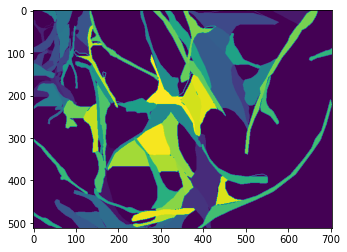

In [62]:
plt.imshow(masks[0])

In [74]:
np.unique(masks[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73], dtype=int32)

In [89]:
bboxes = _tf_compute_bboxes(masks[0])
bboxes

<tf.Tensor: shape=(73, 4), dtype=int32, numpy=
array([[164,   0, 190,  29],
       [314, 170, 369, 196],
       [154,   0, 167,  43],
       [372, 155, 504, 229],
       [  0, 563,  35, 655],
       [ 49,  90, 107, 132],
       [ 23,   0, 103,  50],
       [136,   0, 206,  76],
       [291, 368, 469, 446],
       [146,  52, 222, 104],
       [415, 349, 512, 419],
       [119,  22, 141,  49],
       [127, 466, 266, 510],
       [ 93,   0, 134,  35],
       [ 88,  55, 147,  86],
       [  0, 366,  58, 579],
       [ 29,   0,  99,  57],
       [ 58,  32, 145,  63],
       [  0, 101,  87, 139],
       [445,  51, 512, 152],
       [ 53, 377, 280, 508],
       [ 39, 406, 101, 464],
       [480, 305, 512, 366],
       [473,  99, 512, 174],
       [488, 262, 512, 333],
       [423,  96, 512, 278],
       [172,  35, 268,  85],
       [  0,  53,  59,  93],
       [ 33,  58, 114,  86],
       [126,   0, 160,  52],
       [172,   0, 233,  69],
       [  0,  11,  29,  56],
       [113, 494, 224, 57

In [83]:
mask_bbox = _build_mask_from_bbox(masks[0].squeeze().shape, bboxes[8])
mask_bbox.shape

TensorShape([512, 704])

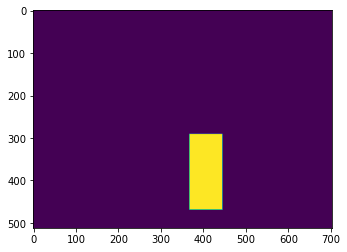

In [84]:
plt.imshow(mask_bbox)

In [123]:
mask_bbox = _generate_bbox_mask((512, 704), bboxes, 5, 16000)
mask_bbox.shape

bboxes shape: (73, 4)
bboxes_sample shape: (1, 4)
In pad shape: (1, 1, 4)
bboxes_pad shape: (1, 4)


TensorShape([512, 704])

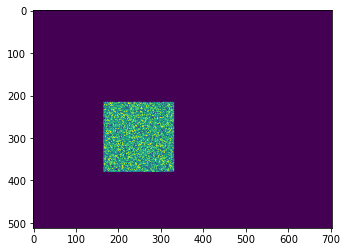

In [124]:
plt.imshow(mask_bbox)

In [96]:
a1, a2, a3, a4 = tf.unstack(tf.reshape(tf.range(4), [1, 1, 4]), axis=-1)
a1, a2, a3, a4

(<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[3]], dtype=int32)>)

In [137]:
y_pred = tf.random.uniform(masks[0:1].shape[:3] + (8,))

loss = ContrastiveLossWithBboxes()(masks[0:1], y_pred)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=9.318338>